# Main area

In [1]:
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rsgislib
import rsgislib.imagecalc
import rsgislib.imagecalc.calcindices
from rsgislib import imageutils
import rsgislib.imageutils
import rsgislib.rastergis

### Variables

In [2]:
#filepath = ''
#filepath = ''
filepath = 'C:\\Users\\tschr\\Desktop\\Landsat\\Data\\'
#output = ''
#output = ''
output = 'C:\\Users\\tschr\\Desktop\\Landsat\\Data\\output\\'

# Me

In [3]:
# set an imput filepath for landsat images
imagepath = filepath + '\\Images\\'


#set lists for study area images
beach = []

year = 1986
for i in range(0,18):
    beach.append(imagepath + str(year) + ".TIF")
    year += 2
    

In [4]:
beach_ndvi = []

for i in range(0,18):
    
    name = output + beach[i][-8:-4] + '_ndvi' + beach[i][-4:]
    rsgislib.imagecalc.calcindices.calc_ndvi(beach[i], 3, 4, name, 
                                                    calc_stats=True, 
                                                    gdalformat='GTIFF')
    
    beach_ndvi.append(name)


In [5]:
sandDuneList = []

for i in beach_ndvi:

    name = output + i[-13:-9] + '_sandAndDune' + i[-4:]
    sandDuneList.append(name)
        
    band_defns = [rsgislib.imagecalc.BandDefn("ndvi", i, 1)]   
    exp = 'ndvi<-0.039?0:ndvi<=0.04?1:ndvi<0.05?0:ndvi>=0.25?0:2'
    rsgislib.imagecalc.band_math(name, exp, "GTIFF", 
                                        rsgislib.TYPE_8UINT, band_defns)
    rsgislib.imageutils.pop_thmt_img_stats(name,True,0.,True)
    year += 2
        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.17it/s]


In [6]:

d = pd.DataFrame({'TotalPixles':[], 'SandPixles':[], 'DunePixles':[], 'BothPixles':[], 
                  'BeachPixlesPercent':[], 'DunePixlesPercent':[], 'BothPixlesPercent':[]})
index = 0
for i in sandDuneList:
    src = rasterio.open(i)
    srcRead = src.read(1)
    unique, counts = np.unique(srcRead, return_counts=True)
    d.loc[index] = [counts[0], counts[1], counts[2], counts[1] + counts[2], 
                        (counts[1] / counts[0])*100, (counts[2] / counts[0])*100, 
                        ((counts[1] + counts[2]) / counts[0] )*100]
    index += 1

In [7]:
d.head(13)

,TotalPixles,SandPixles,DunePixles,BothPixles,BeachPixlesPercent,DunePixlesPercent,BothPixlesPercent
0,2084747.0,1572.0,3148.0,4720.0,0.075405,0.151002,0.226406
1,2083108.0,2304.0,4055.0,6359.0,0.110604,0.194661,0.305265
2,2083992.0,2122.0,3353.0,5475.0,0.101824,0.160893,0.262717
3,2079774.0,2272.0,7421.0,9693.0,0.109243,0.356818,0.466060
4,2084036.0,1881.0,3550.0,5431.0,0.090258,0.170343,0.260600
5,2084124.0,1805.0,3538.0,5343.0,0.086607,0.169760,0.256367
6,2084304.0,1783.0,3380.0,5163.0,0.085544,0.162164,0.247709
7,2083460.0,2733.0,3274.0,6007.0,0.131176,0.157142,0.288318
8,2083320.0,2388.0,3759.0,6147.0,0.114625,0.180433,0.295058
9,2083140.0,2493.0,3834.0,6327.0,0.119675,0.184049,0.303724


# Not me

In [8]:
storm85 = pd.read_csv(filepath + '85data.csv')

In [9]:
#years 1985-2001
storm85 = pd.read_csv(filepath + "85data.csv")
# read CSV files 2002-2020
storm1 = pd.read_csv(filepath + "storm_data_01-01-2000_12-31-2005.csv")
storm2 = pd.read_csv(filepath + "storm_data_01-01-2006_12-31-2009.csv")
storm3 = pd.read_csv(filepath + "storm_data_01-01-2010_12-31-2012.csv")
storm4 = pd.read_csv(filepath + "storm_data_01-01-2013_12-31-2017.csv")
storm5 = pd.read_csv(filepath + "storm_data_01-01-2018_12-31-2020.csv")
storm02 = pd.concat([storm1, storm2, storm3, storm4, storm5], axis=0)

In [10]:
# change first dataset index to year
storm85 = storm85.set_index('year')
# calculate number of events
storm85['number_events'] = storm85.sum(axis = 1)
#drop month columns
storm85 = storm85.drop(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'], axis=1)

In [11]:
# change column names to match first dataset
storm02.rename(columns={'BEGIN_DATE':'year', 'EVENT_ID': 'number_events'}, inplace=True)
# change date type from object to datetime
storm02['year'] = pd.to_datetime(storm02.year, format='%m/%d/%Y')
# selects winds with magnitude over 50
mag = storm02['MAGNITUDE'] >= 50
storm02 = storm02[mag]
# count dataset events by year
storm02 = storm02.groupby(storm02.year.dt.year)['number_events'].count()
storm02 = pd.DataFrame(storm02)

In [12]:
storms = pd.concat([storm85,storm02], axis=0)

In [13]:
stormdataset = {'year': ['1986','1988','1990','1992','1994','1996','1998','2000','2002','2004','2006','2008','2010','2012','2014','2016','2018','2020'],
               'number_of_events': [(storms.iloc[[0,1]].mean()['number_events']),(storms.iloc[[2,3]].mean()['number_events']),
                                 (storms.iloc[[4,5]].mean()['number_events']),(storms.iloc[[6,7]].mean()['number_events']),
                                 (storms.iloc[[8,9]].mean()['number_events']),(storms.iloc[[10,11]].mean()['number_events']),
                                 (storms.iloc[[12,13]].mean()['number_events']),(storms.iloc[[14,15]].mean()['number_events']),
                                 (storms.iloc[[16,17]].mean()['number_events']),(storms.iloc[[18,19]].mean()['number_events']),
                                 (storms.iloc[[20,21]].mean()['number_events']),(storms.iloc[[22,23]].mean()['number_events']),
                                 (storms.iloc[[24,25]].mean()['number_events']),(storms.iloc[[26,27]].mean()['number_events']),
                                 (storms.iloc[[28,29]].mean()['number_events']),(storms.iloc[[30,31]].mean()['number_events']),
                                 (storms.iloc[[32,33]].mean()['number_events']),(storms.iloc[[34,35]].mean()['number_events'])]}
stormdataset = pd.DataFrame(data=stormdataset)

stormdataset

,year,number_of_events
0,1986,17.0
1,1988,30.5
2,1990,26.0
3,1992,24.5
4,1994,29.0
5,1996,30.5
6,1998,37.5
7,2000,35.5
8,2002,34.5
9,2004,28.5


In [14]:
#import data
waterdata = pd.read_csv(filepath + "waterdata.csv")
waterdata = waterdata.drop(['month','Superior','St. Clair', 'Erie','Ontario'], axis=1)
waterdata.head()

,year,Michigan-Huron
0,1985,176.88
1,1985,176.86
2,1985,176.98
3,1985,177.14
4,1985,177.24


In [15]:
# Find yearly averages
waterdata = waterdata.groupby(waterdata['year']).mean()
water = waterdata.groupby(np.arange(len(waterdata))//2).mean()
water.head()

,Michigan-Huron
0,177.209583
1,176.767083
2,176.375417
3,176.474167
4,176.687083


In [16]:
year= ['1986','1988','1990','1992','1994','1996','1998','2000','2002','2004','2006','2008','2010','2012','2014','2016','2018','2020']
water.insert(0, 'year', year)
#water['year'] = year
water = water.rename(columns={'Michigan-Huron': 'water_level'})

In [17]:
water

,year,water_level
0,1986,177.209583
1,1988,176.767083
2,1990,176.375417
3,1992,176.474167
4,1994,176.687083
5,1996,176.590833
6,1998,176.850417
7,2000,176.107083
8,2002,176.034583
9,2004,176.001250


In [18]:
#Storm and Water Level Dataset
storm_water = (pd.merge(water, stormdataset, on='year'))
storm_water

,year,water_level,number_of_events
0,1986,177.209583,17.0
1,1988,176.767083,30.5
2,1990,176.375417,26.0
3,1992,176.474167,24.5
4,1994,176.687083,29.0
5,1996,176.590833,30.5
6,1998,176.850417,37.5
7,2000,176.107083,35.5
8,2002,176.034583,34.5
9,2004,176.001250,28.5


# Also, Not me

In [19]:
# Read precipitation dataset old
#precipitation_dt = pd.read_csv('C:/Users/Dalton/Desktop/School/Winter_2023/GIS_490/Final_proj/data/Precipitation_final.csv')
#precipitation_dt.head()

In [20]:
# Read precipitation dataset new
precipitation_dt = pd.read_csv(filepath + 'Precipitation_final.csv')
precipitation_dt.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,1985,2.17,4.78,3.50,2.00,1.97,3.47,3.49,4.40,2.81,3.27,9.00,2.37,43.23
1,1986,1.78,2.22,2.17,1.94,3.70,4.85,5.24,2.42,5.61,2.93,3.96,1.49,38.31
2,1987,2.13,0.50,0.91,2.13,5.08,3.24,4.76,6.94,3.23,4.43,1.65,5.45,40.45
3,1988,2.73,2.36,3.38,3.50,1.38,2.05,2.77,3.75,1.90,5.74,5.97,2.18,37.71
4,1989,1.43,1.49,2.16,2.33,3.40,4.23,2.98,4.58,4.29,1.94,3.53,2.92,35.28


In [21]:
#array Testing

In [22]:
#array for precip

In [23]:
#remove
#get precip dt without 1985
#remove1985_precip = precipitation_dt[precipitation_dt["Year"] != 1985]
#remove1985_precip

In [24]:
#remove
#only get the Annual precip column
#remove1985_precip_mean = remove1985_precip["Annual"]
#remove1985_precip_mean

In [25]:
#only get the Annual precip column
precip_annual = precipitation_dt["Annual"]
precip_annual

0     43.23
1     38.31
2     40.45
3     37.71
4     35.28
5     62.21
6     47.20
7     46.09
8     51.63
9     34.48
10    37.05
11    46.08
12    41.72
13    35.30
14    35.31
15    43.06
16    46.68
17    32.37
18    33.08
19    44.43
20    33.34
21    46.82
22    46.10
23    56.66
24    45.25
25    40.96
26    46.10
27    32.33
28    44.85
29    45.24
30    37.02
31    45.83
32    47.50
33    46.44
34    49.35
35    36.95
Name: Annual, dtype: float64

In [26]:
#variable to mean of every N years
#N = 5
N = 2

In [27]:
# getting the precipitation average of every N (2) years
new_precip_df = precip_annual.groupby(precip_annual.index // N).mean()
new_precip_df

0     40.770
1     39.080
2     48.745
3     46.645
4     43.055
5     41.565
6     38.510
7     39.185
8     39.525
9     38.755
10    40.080
11    51.380
12    43.105
13    39.215
14    45.045
15    41.425
16    46.970
17    43.150
Name: Annual, dtype: float64

In [28]:
#remove
#get an array for the mean every 5 years

#array_precip = remove1985_precip_mean.values.reshape(-1, N).mean(1)
#array_precip

In [29]:
#end array for precip

In [30]:
#get value for 1985, in order to add to array

In [31]:
#get only data for 1985
#only1985_precip = precipitation_dt[precipitation_dt["Year"] == 1985]
#only1985_precip

In [32]:
#only1985_precip_mean = only1985_precip["Annual"]
#only1985_precip_mean

In [33]:
#add the 1985 mean to the array : array_test    only1985_mean
#full_array_precip = np.append(only1985_precip_mean, array_precip)
#full_array_precip

In [34]:
#end adding 1985 mean to array

In [35]:
#turnning the array into a df

In [36]:
#array into a df
#new_precip_df = pd.DataFrame(full_array_precip, columns = ['5 year mean precip'])
#new_precip_df

In [37]:
#end making a dt for precip array

In [38]:
#create an array/dt with the years column

In [39]:
#create a year array
year_array = pd.array([1986, 1988, 1990, 1992, 1994, 1996, 1998,
                       2000, 2002, 2004, 2006, 2008, 2010,
                       2012, 2014, 2016, 2018, 2020])
year_array

<IntegerArray>
[1986, 1988, 1990, 1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010,
 2012, 2014, 2016, 2018, 2020]
Length: 18, dtype: Int64

In [40]:
#create a df with years
new_year_df = pd.DataFrame(year_array, columns = ['year'])
new_year_df

,year
0,1986
1,1988
2,1990
3,1992
4,1994
5,1996
6,1998
7,2000
8,2002
9,2004


In [41]:
#end making a df with years

In [42]:
#join year df with precip df

In [43]:
#join with concat : new_year_df    new_precip_df
concat_df = pd.concat([new_year_df, new_precip_df], axis=1)
concat_df

,year,Annual
0,1986,40.770
1,1988,39.080
2,1990,48.745
3,1992,46.645
4,1994,43.055
5,1996,41.565
6,1998,38.510
7,2000,39.185
8,2002,39.525
9,2004,38.755


In [44]:
#read in ice data

In [45]:
# Read ice dataset old
#ice_dt = pd.read_csv('C:/Users/Dalton/Desktop/School/Winter_2023/GIS_490/Final_proj/data/max_ice_coverage.csv')
#ice_dt.head()

In [46]:
# Read precipitation dataset new
ice_dt = pd.read_csv(filepath + 'max_ice_coverage.csv')
ice_dt.head()

,year,cover,date
0,1985,41.3,23-Feb
1,1986,66.8,23-Feb
2,1987,20.0,21-Feb
3,1988,32.7,7-Feb
4,1989,30.9,19-Mar


In [47]:
#array for ice

In [48]:
#remove
#get ice dt without 1985
#remove1985_ice = ice_dt[ice_dt["year"] != 1985]
#remove1985_ice

In [49]:
#only get the cover (Annual) ice column
ice_cover = ice_dt["cover"]
ice_cover

0     41.3
1     66.8
2     20.0
3     32.7
4     30.9
5     32.4
6     21.5
7     32.8
8     32.2
9     82.7
10    21.6
11    75.0
12    37.8
13    15.1
14    23.0
15    27.2
16    29.5
17    12.4
18    48.0
19    36.4
20    29.4
21    16.1
22    37.2
23    33.5
24    52.3
25    23.5
26    29.4
27    16.7
28    24.4
29    93.1
30    72.9
31    26.8
32    18.2
33    51.3
34    55.8
35    17.2
Name: cover, dtype: float64

In [50]:
# getting the precipitation average of every N (2) years
new_ice_df = ice_cover.groupby(ice_cover.index // N).mean()
new_ice_df

0     54.05
1     26.35
2     31.65
3     27.15
4     57.45
5     48.30
6     26.45
7     25.10
8     20.95
9     42.20
10    22.75
11    35.35
12    37.90
13    23.05
14    58.75
15    49.85
16    34.75
17    36.50
Name: cover, dtype: float64

In [51]:
#remove
#get an ice array for the mean every 5 years
#array_ice_mean = remove1985_ice_mean.values.reshape(-1, N).mean(1)
#array_ice_mean

In [52]:
#end array for ice

In [53]:
#get value for 1985, in order to add to array

In [54]:
#remove
#get only data for 1985
#only1985_ice = ice_dt[ice_dt["year"] == 1985]
#only1985_ice

In [55]:
#remove
#get only cover
#only1985_ice_mean = only1985_ice["cover"]
#only1985_ice_mean

In [56]:
#remove
#add the 1985 ice mean to the ice array : array_ice_mean    only1985_ice_mean
#full_ice_array = np.append(only1985_ice_mean, array_ice_mean)
#full_ice_array

In [57]:
#end adding 1985 ice mean to array

In [58]:
#turnning the ice array into a df

In [59]:
#remove
#ice array into an ice df
#new_ice_df = pd.DataFrame(full_ice_array, columns = ['5 year mean ice'])
#new_ice_df

In [60]:
#end making a dt for precip array

In [61]:
#join concat_df df with ice df

In [62]:
#join with concat : new_year_df    new_precip_df
final_df = pd.concat([concat_df, new_ice_df], axis=1)
final_df

,year,Annual,cover
0,1986,40.770,54.05
1,1988,39.080,26.35
2,1990,48.745,31.65
3,1992,46.645,27.15
4,1994,43.055,57.45
5,1996,41.565,48.30
6,1998,38.510,26.45
7,2000,39.185,25.10
8,2002,39.525,20.95
9,2004,38.755,42.20


In [63]:
#end concat of df

# Merging data tables

final_concat_df <br>
storm_water<br>
d<br>

In [64]:
final_df = pd.concat([storm_water, new_ice_df, new_precip_df, d], axis=1)
final_df

,year,water_level,number_of_events,cover,Annual,TotalPixles,SandPixles,DunePixles,BothPixles,BeachPixlesPercent,DunePixlesPercent,BothPixlesPercent
0,1986,177.209583,17.0,54.05,40.770,2084747.0,1572.0,3148.0,4720.0,0.075405,0.151002,0.226406
1,1988,176.767083,30.5,26.35,39.080,2083108.0,2304.0,4055.0,6359.0,0.110604,0.194661,0.305265
2,1990,176.375417,26.0,31.65,48.745,2083992.0,2122.0,3353.0,5475.0,0.101824,0.160893,0.262717
3,1992,176.474167,24.5,27.15,46.645,2079774.0,2272.0,7421.0,9693.0,0.109243,0.356818,0.466060
4,1994,176.687083,29.0,57.45,43.055,2084036.0,1881.0,3550.0,5431.0,0.090258,0.170343,0.260600
5,1996,176.590833,30.5,48.30,41.565,2084124.0,1805.0,3538.0,5343.0,0.086607,0.169760,0.256367
6,1998,176.850417,37.5,26.45,38.510,2084304.0,1783.0,3380.0,5163.0,0.085544,0.162164,0.247709
7,2000,176.107083,35.5,25.10,39.185,2083460.0,2733.0,3274.0,6007.0,0.131176,0.157142,0.288318
8,2002,176.034583,34.5,20.95,39.525,2083320.0,2388.0,3759.0,6147.0,0.114625,0.180433,0.295058
9,2004,176.001250,28.5,42.20,38.755,2083140.0,2493.0,3834.0,6327.0,0.119675,0.184049,0.303724


# Visulizations

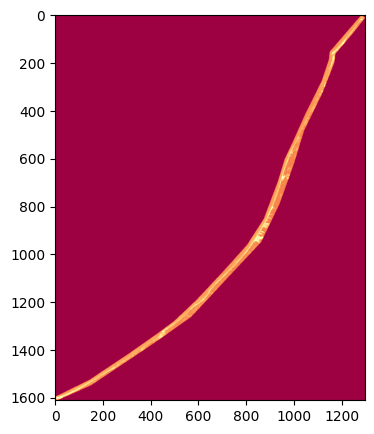

In [65]:
file = rasterio.open(filepath + 'Images\\2010.tif')
dataset = file.read()

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(dataset[0,:,:], cmap='Spectral')
plt.show()

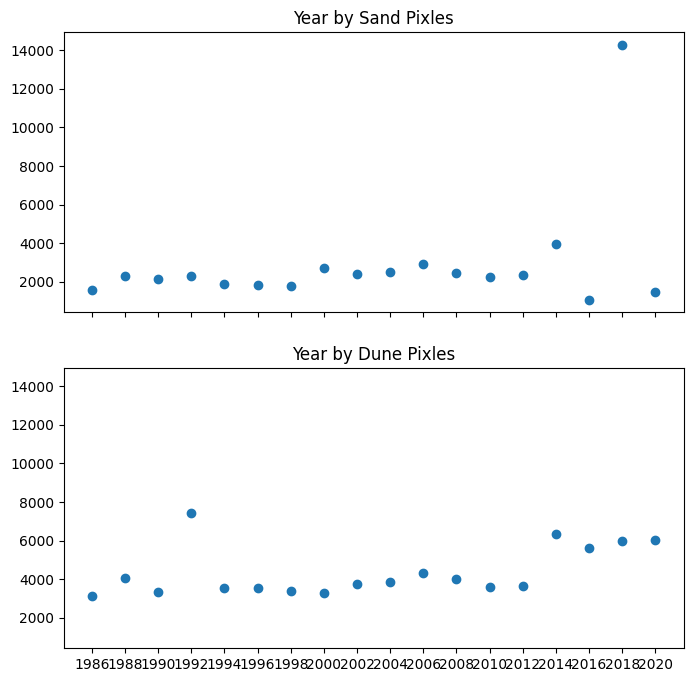

In [66]:
fig, ax = plt.subplots(2,1, sharey=True, sharex=True, figsize=(8,8))

ax[0].scatter(final_df['year'],final_df['SandPixles'])
ax[0].set_title('Year by Sand Pixles')
ax[1].scatter(final_df['year'],final_df['DunePixles'])
ax[1].set_title('Year by Dune Pixles')

plt.show()

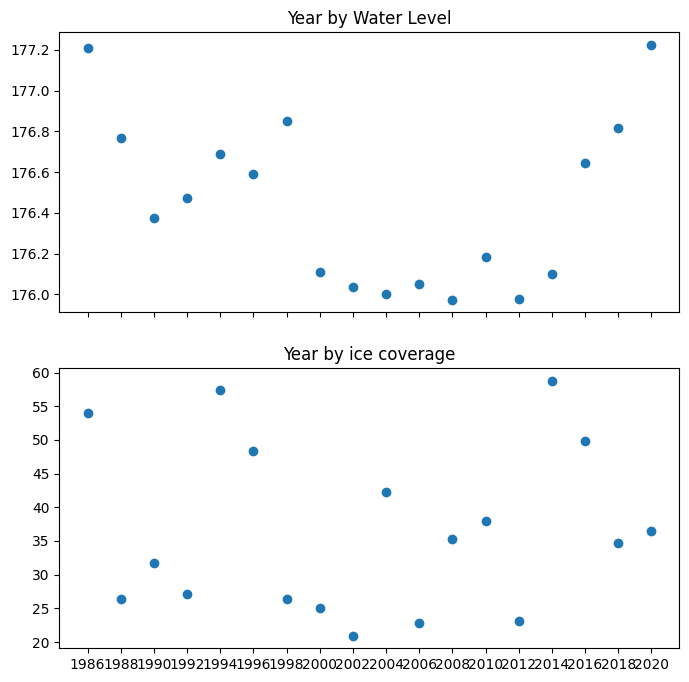

In [67]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,8))

ax[0].scatter(final_df['year'],final_df['water_level'])
ax[0].set_title('Year by Water Level')
ax[1].scatter(final_df['year'],final_df['cover'])
ax[1].set_title('Year by ice coverage')

plt.show()

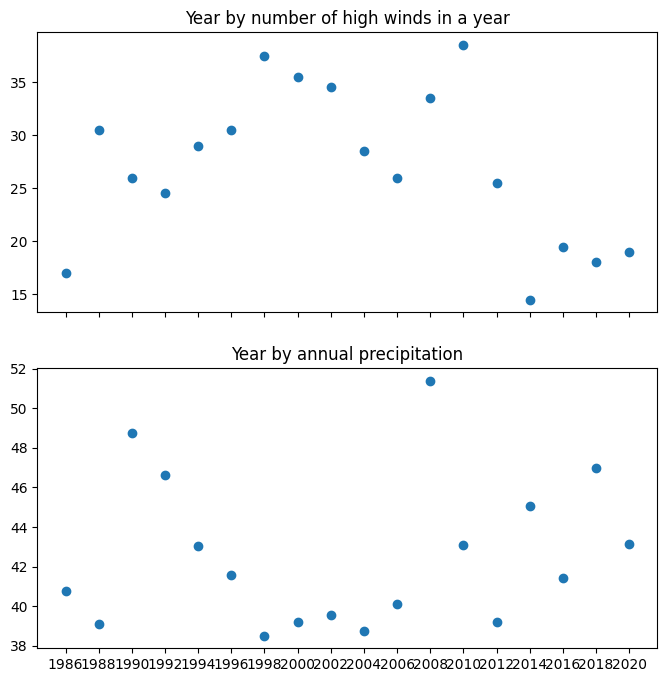

In [68]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,8))

ax[0].scatter(final_df['year'],final_df['number_of_events'])
ax[0].set_title('Year by number of high winds in a year')
ax[1].scatter(final_df['year'],final_df['Annual'])
ax[1].set_title('Year by annual precipitation')

plt.show()

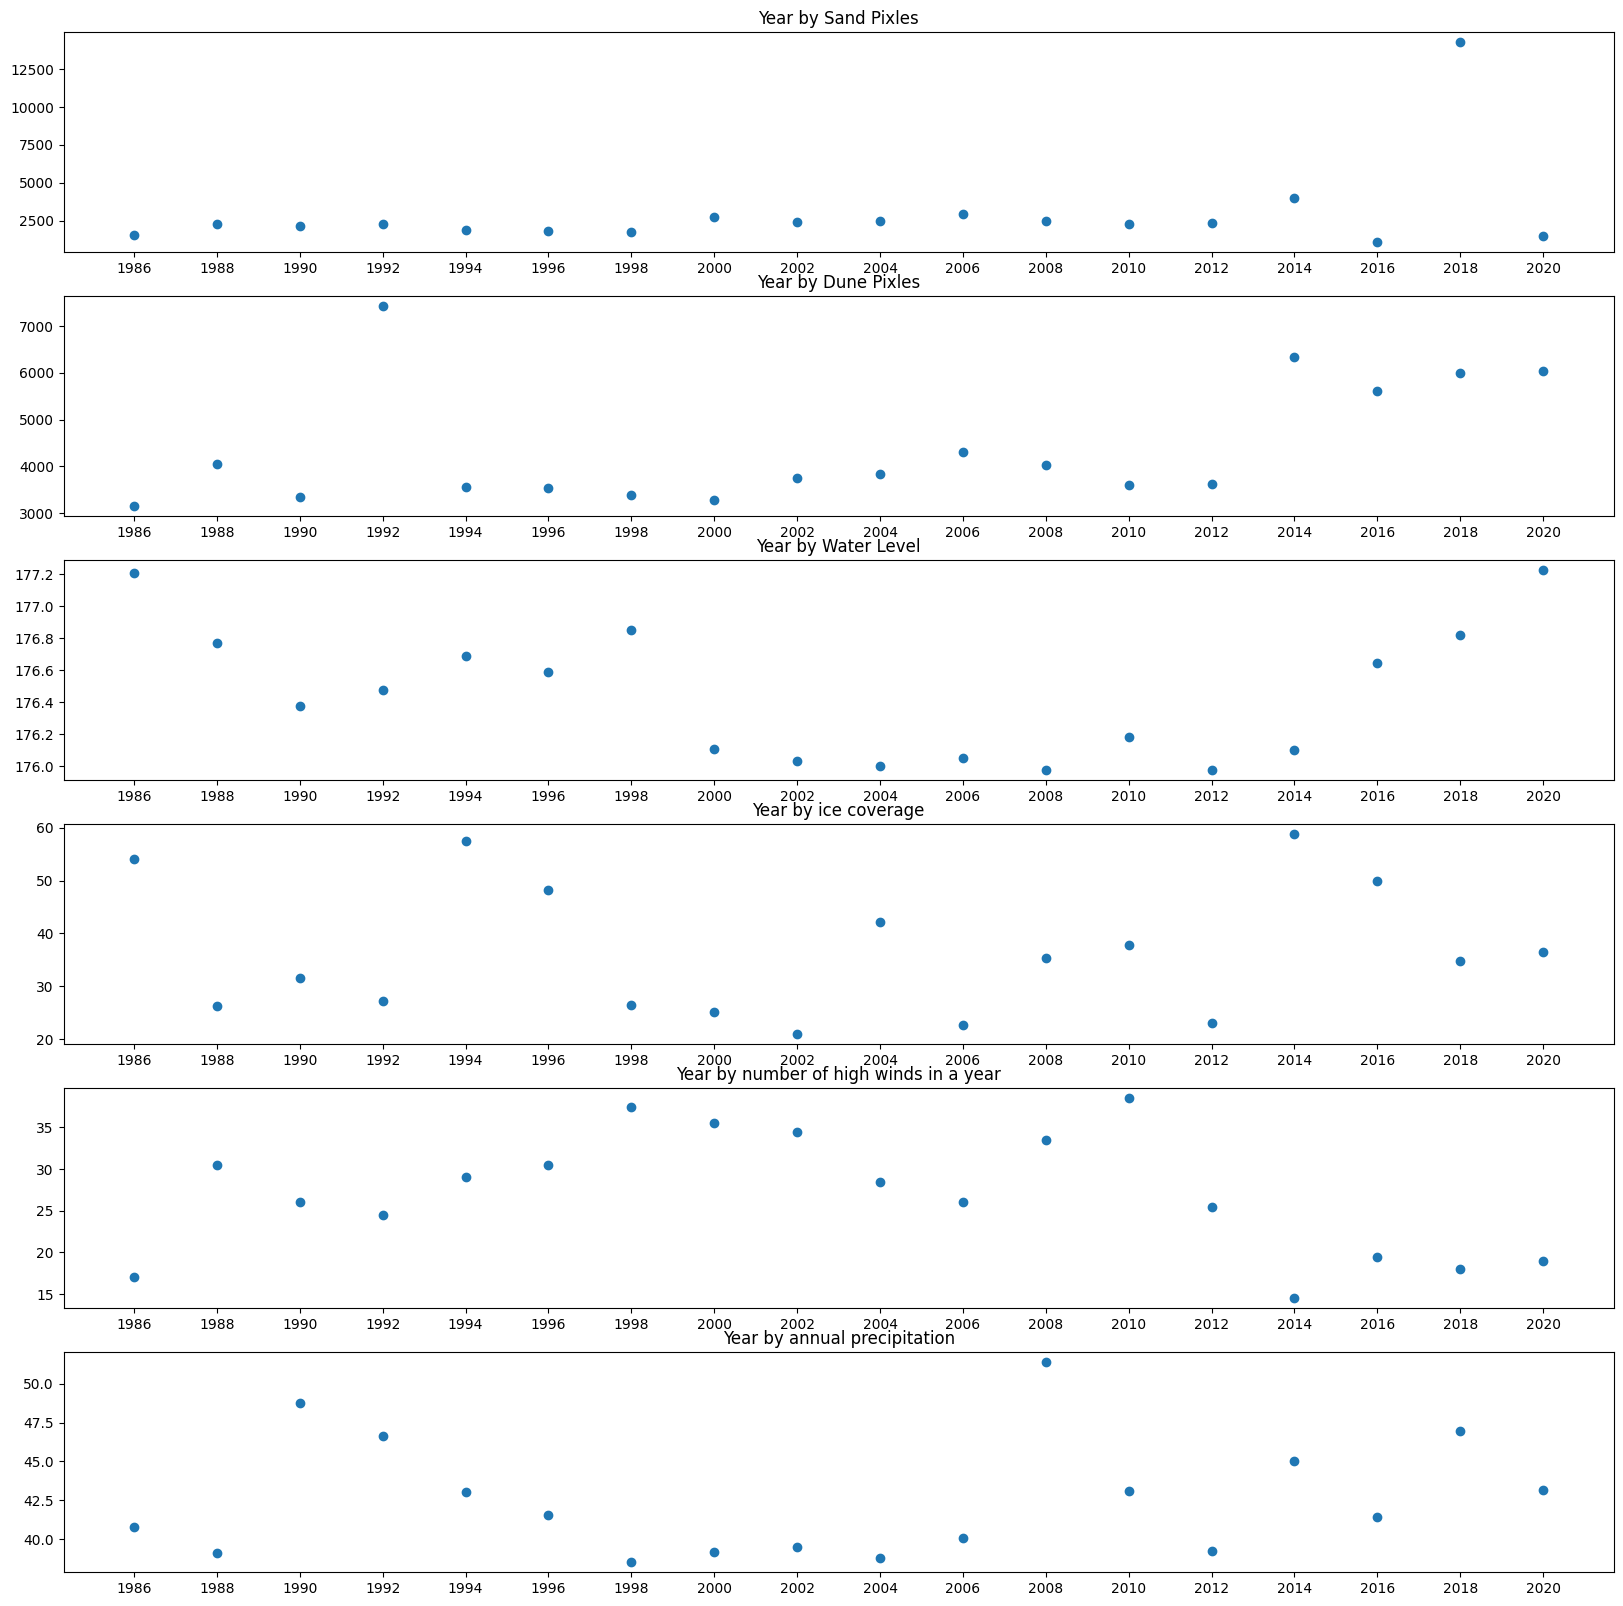

In [69]:
fig, ax = plt.subplots(6,1, figsize=(20, 20))

ax[0].scatter(final_df['year'],final_df['SandPixles'])
ax[0].set_title('Year by Sand Pixles')
ax[1].scatter(final_df['year'],final_df['DunePixles'])
ax[1].set_title('Year by Dune Pixles')
ax[2].scatter(final_df['year'],final_df['water_level'])
ax[2].set_title('Year by Water Level')
ax[3].scatter(final_df['year'],final_df['cover'])
ax[3].set_title('Year by ice coverage')
ax[4].scatter(final_df['year'],final_df['number_of_events'])
ax[4].set_title('Year by number of high winds in a year')
ax[5].scatter(final_df['year'],final_df['Annual'])
ax[5].set_title('Year by annual precipitation')
plt.show()

In [70]:
#start histograms

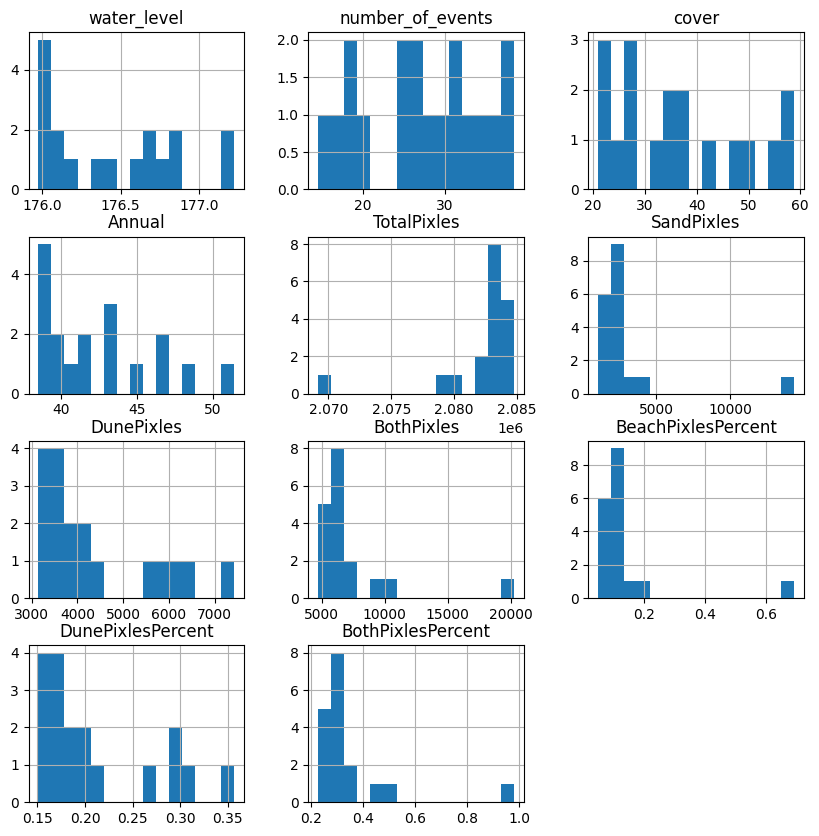

In [71]:
# Plot histogram: will need to adjust bins
final_df_hist = final_df.hist(bins=15 , figsize=(10, 10))

In [72]:
#end histogram

In [73]:
#start cor. mat.

#need to replace cor. value withcolumn heads

In [74]:
# Compute correlation matrix
sand_corr_matrix = final_df.corr()

# Display just dune value correlations
#replace years with dune
sand_corr_matrix["SandPixles"].sort_values(ascending= False)

C:\Users\tschr\AppData\Local\Temp\ipykernel_29964\192814367.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sand_corr_matrix = final_df.corr()


SandPixles            1.000000
BeachPixlesPercent    0.999999
BothPixlesPercent     0.940165
BothPixles            0.939559
DunePixlesPercent     0.338195
DunePixles            0.332556
Annual                0.305344
water_level           0.068513
cover                -0.060401
number_of_events     -0.303373
TotalPixles          -0.939559
Name: SandPixles, dtype: float64

In [75]:
# Compute correlation matrix
dune_corr_matrix = final_df.corr()

# Display just beach value correlations
dune_corr_matrix["DunePixles"].sort_values(ascending= False)

C:\Users\tschr\AppData\Local\Temp\ipykernel_29964\3557494227.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dune_corr_matrix = final_df.corr()


DunePixles            1.000000
DunePixlesPercent     0.999982
BothPixles            0.635356
BothPixlesPercent     0.633983
Annual                0.388140
BeachPixlesPercent    0.332959
SandPixles            0.332556
water_level           0.159995
cover                 0.101625
number_of_events     -0.603652
TotalPixles          -0.635356
Name: DunePixles, dtype: float64

In [76]:
# Compute correlation matrix
beach_and_dune_corr_matrix = final_df.corr()

# Display just dune value correlations
beach_and_dune_corr_matrix["BothPixles"].sort_values(ascending= False)

C:\Users\tschr\AppData\Local\Temp\ipykernel_29964\1459352015.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  beach_and_dune_corr_matrix = final_df.corr()


BothPixles            1.000000
BothPixlesPercent     0.999998
BeachPixlesPercent    0.939704
SandPixles            0.939559
DunePixlesPercent     0.639967
DunePixles            0.635356
Annual                0.390938
water_level           0.114186
cover                -0.012563
number_of_events     -0.467566
TotalPixles          -1.000000
Name: BothPixles, dtype: float64

In [ ]:
#end cor. mat.

In [ ]:
#start regresion

# all features will need to be updated

In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler

# Define feature list
feature_list =  ['precip', 'ice', 'storm', 'water']

# Define features and labels 
X = final_concat_df[feature_list]
y = final_concat_df['dune']

In [ ]:
# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
final_dt_rough_scaled = pd.DataFrame(X_scaled, columns=feature_list)
final_dt_rough_scaled

In [ ]:
from sklearn.model_selection import train_test_split

# Split data 
X_train, X_test, y_train, y_test = train_test_split(final_dt_rough_scaled, y, test_size=0.5, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression

# Define model
lin_reg = LinearRegression()

# Fit model to data
lin_reg.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error

# Predict test labels
predictions = lin_reg.predict(X_test)

# Compute mean-squared-error
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,100], [0, 100], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted dune change', fontsize=14)
ax.set_xlabel('Observed dune change', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,100)
ax.set_xlim(0,100)

# Me plots

# Not me plots

# Also not me plots

# Corrilation

# Regression